# Tercer Examen Parcial (Práctico)
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto  | 745697

--- 




### Librerías: 

In [310]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb 
from xgboost import  XGBRegressor, XGBClassifier, plot_importance as xgb_plot_importance, callback as xgb_callback
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor,LGBMClassifier, plot_importance,early_stopping, log_evaluation

warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

---

### Dataset : 
Diabetes

In [311]:
df = pd.read_csv('diabetes.csv')

In [312]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


#### Dummies

In [313]:
df = pd.get_dummies(df, drop_first=True)
df

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,0,False,False,False,False,False,False,False
99996,2.0,0,0,17.37,0,False,False,False,False,False,False,False
99997,66.0,0,0,27.83,0,True,False,False,False,True,False,False
99998,24.0,0,0,35.42,0,False,False,False,False,False,True,False


### Visualización del Dataset

In [314]:
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False


In [315]:
print(df.columns)


Index(['age', 'hypertension', 'heart_disease', 'bmi', 'diabetes',
       'gender_Male', 'gender_Other', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')


### Explicación de las variables

---

#### Se busca predecir

In [316]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### NaN's

In [317]:
pd.DataFrame(df.isnull().sum()).T

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,0,0,0,0,0,0,0,0,0,0,0


Ninguna Variable tiene NaN's , así que podemos continuar

##### Función Calibración 

In [318]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

##### Función Bivariado

In [319]:
def bivariado(df):
    num_features = df.iloc[:, :].columns
    df_numerical = df.iloc[:, :].copy()

    for feature in num_features:
        df_numerical[f'{feature}_bins'] = pd.qcut(df_numerical[feature], q=5, labels=False, duplicates='drop')

        if df_numerical[f'{feature}_bins'].isna().sum() > 0:
            print(f"Advertencia: {feature} tiene valores NaN en la segmentación.")

        grouped = df_numerical.groupby(f'{feature}_bins').mean()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
        
        sns.lineplot(x=grouped[feature], y=grouped[target], marker='o', color='#b30000', ax=axes[0])
        axes[0].set_title(f'Relación de {feature} con {target}')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel(target)
        axes[0].grid()

        sns.histplot(df_numerical[feature], bins=50, color='#b30000', edgecolor='black', kde=True, ax=axes[1])
        axes[1].set_title(f'Distribución de {feature}')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Frecuencia')

        plt.show()


##### Función Lightgbm

In [320]:


def lightgbm(X_train, y_train, X_test, y_test):
    model_lightgbm = LGBMClassifier(
        n_estimators=10000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=20,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_bytree=0.8,
        verbosity=-1
    )

    model_lightgbm.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=100)
        ]
    )

    # Probabilidades de clase positiva
    proba = model_lightgbm.predict_proba(X_test)[:, 1]
    
    # Calcular y mostrar el AUC
    auc_score = roc_auc_score(y_test, proba)
    print("ROC AUC:", auc_score)
    
    # Gráfica de la curva ROC
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - LightGBM')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Importancia de características
    plot_importance(model_lightgbm, max_num_features=5, importance_type='split')
    plot_importance(model_lightgbm, max_num_features=5, importance_type='gain')
    
    return proba



##### Función CatBoost

In [321]:

def catboost(X_train, y_train, X_test, y_test):

    cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')

    # Modelo de clasificación
    model_catboost = CatBoostClassifier(
        iterations=10000,
        depth=5,
        learning_rate=0.1,
        subsample=0.5,
        rsm=0.8,
        eval_metric='AUC',
        verbose=100,
        early_stopping_rounds=50
    )

    # Entrenamiento
    model_catboost.fit(
        X_train, y_train,
        cat_features=cat_cols,
        eval_set=(X_test, y_test)
    )

    # Predicciones de probabilidad
    proba = model_catboost.predict_proba(X_test)[:, 1]

    # AUC
    auc_score = roc_auc_score(y_test, proba)
    print("ROC AUC:", auc_score)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - CatBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calibración (si aplica a tu caso)
    calibracion(proba, y_test, 20)

    # Importancia de variables
    df_importances = pd.DataFrame({
        'feature': model_catboost.feature_names_,
        'importance': model_catboost.feature_importances_
    }).sort_values(by='importance', ascending=False)

    return df_importances.head(5), proba


##### Función XGBoost

In [322]:
from xgboost import XGBClassifier, plot_importance as xgb_plot_importance, callback
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def xgboost(X_train, y_train, X_test, y_test):
    model_xgboost = XGBClassifier(
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.1,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_bytree=0.8,
        tree_method='hist',
        enable_categorical=True,
        use_label_encoder=False,
        eval_metric='auc'
    )

    model_xgboost.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=100,
        callbacks=[callback.EarlyStopping(rounds=20)]  # <-- IMPORTANTE: callback importado correctamente
    )

    # Probabilidades de clase positiva
    proba = model_xgboost.predict_proba(X_test)[:, 1]

    # Calcular AUC
    auc_score = roc_auc_score(y_test, proba)
    print("ROC AUC:", auc_score)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - XGBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calibración personalizada
    calibracion(proba, y_test, 20)

    # Importancia de variables
    xgb_plot_importance(model_xgboost, max_num_features=5, importance_type='weight')
    xgb_plot_importance(model_xgboost, max_num_features=5, importance_type='gain')

    return proba


##### Función Curva AUC

In [323]:
def graficar_curva_roc(y_true, y_score, nombre_modelo='Modelo'):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{nombre_modelo} (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()

#### Bivariado

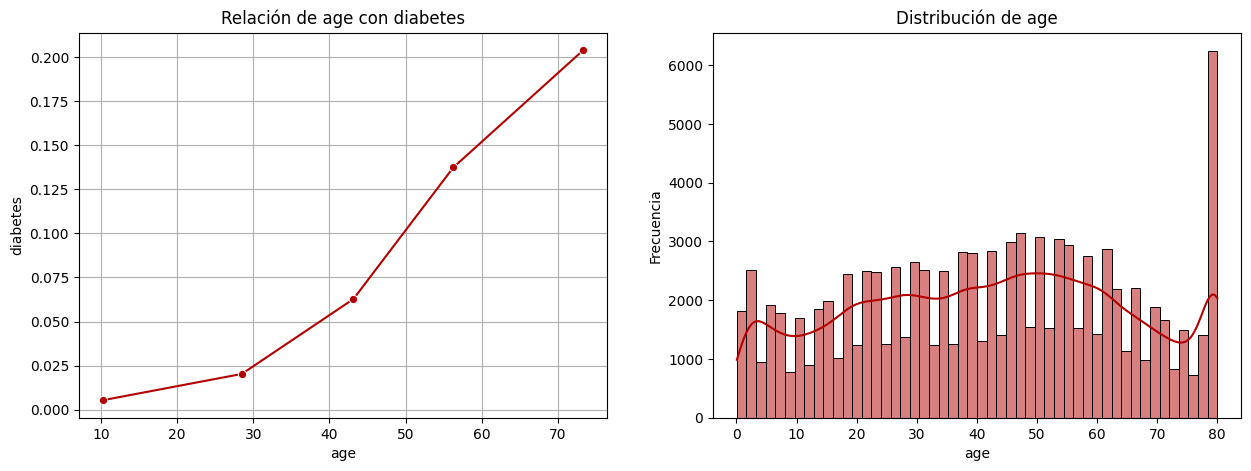

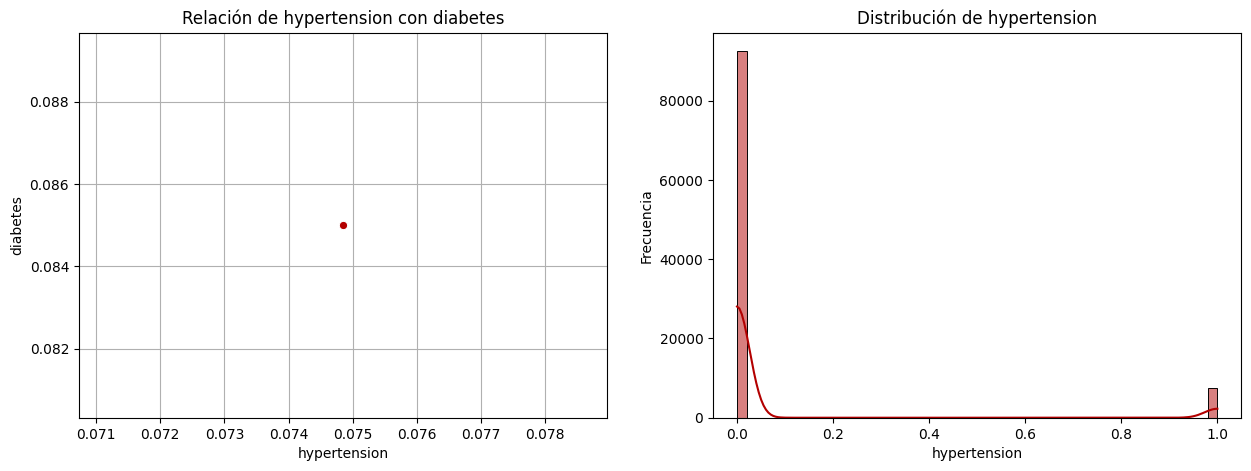

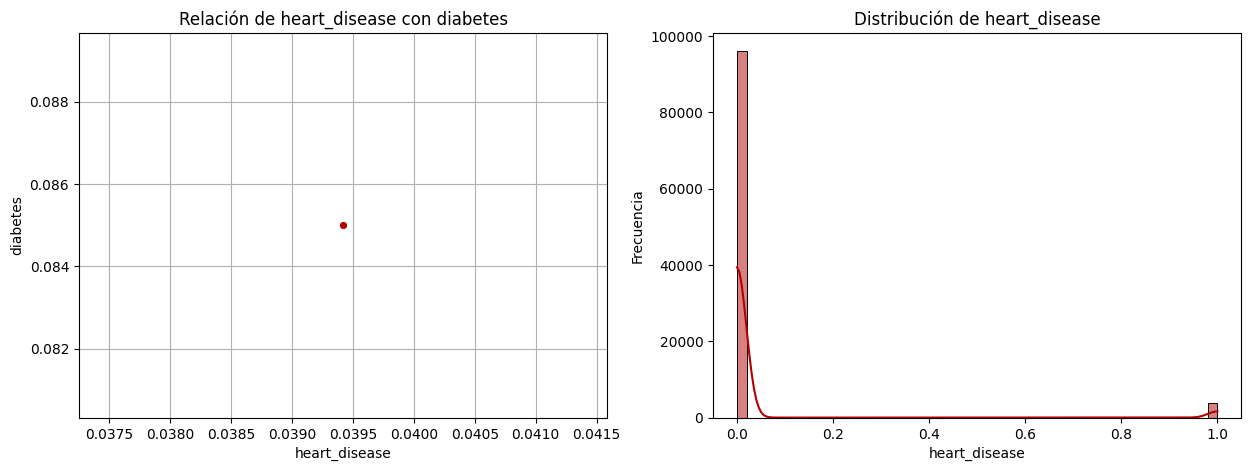

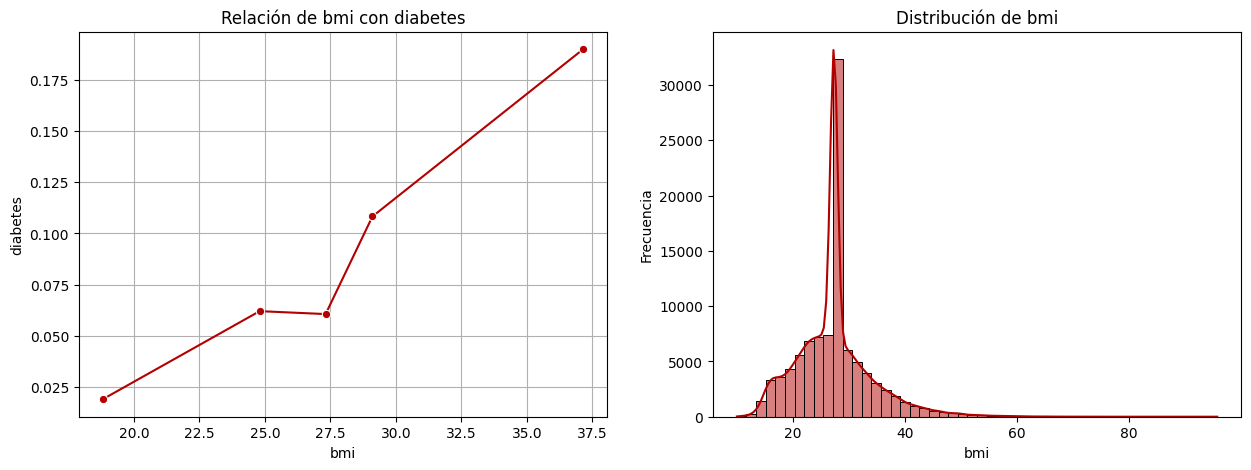

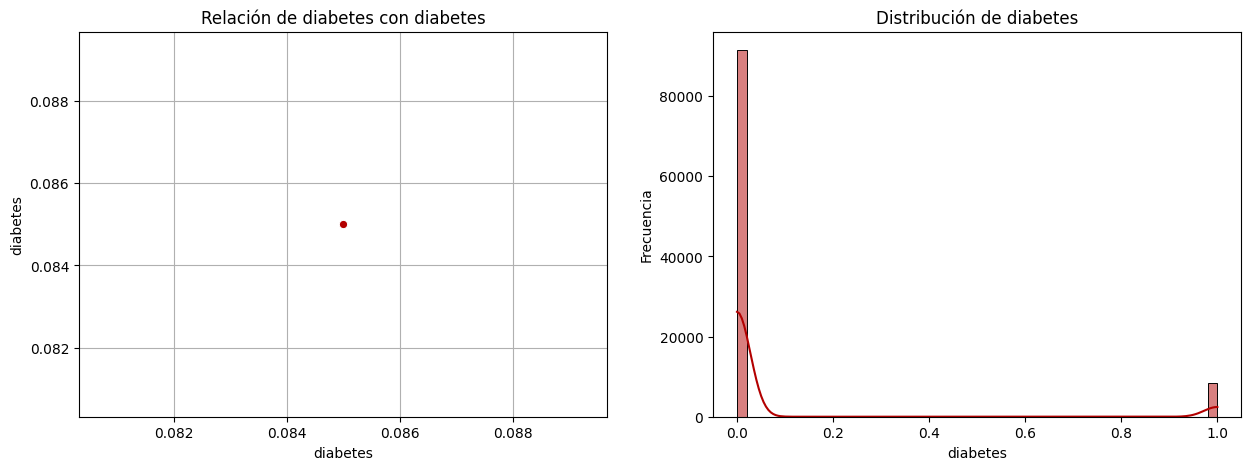

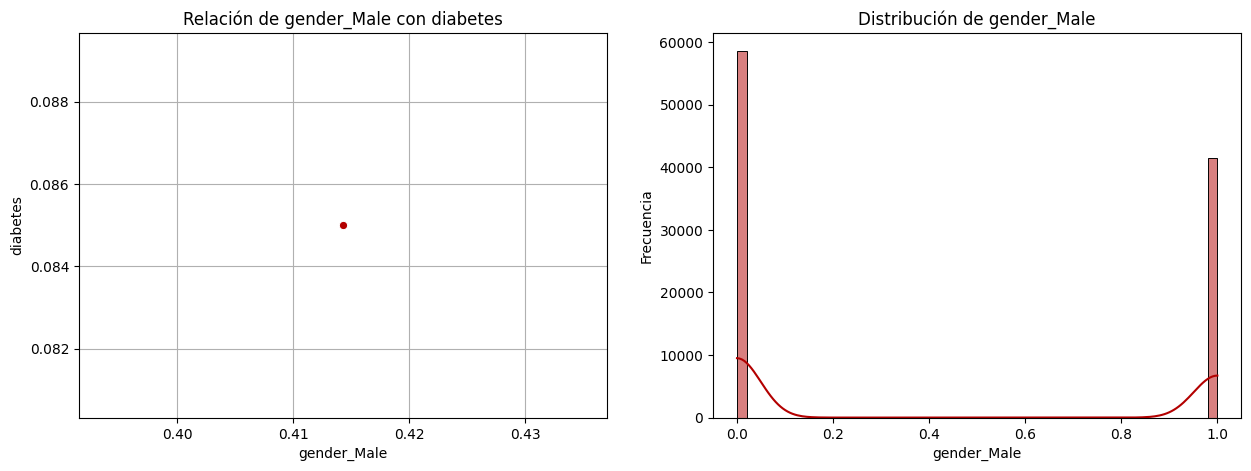

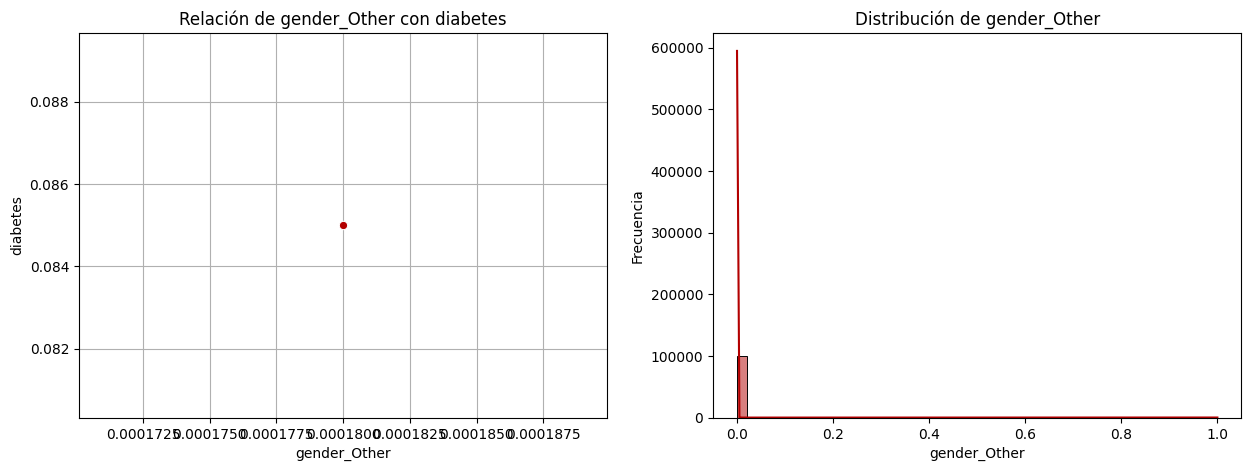

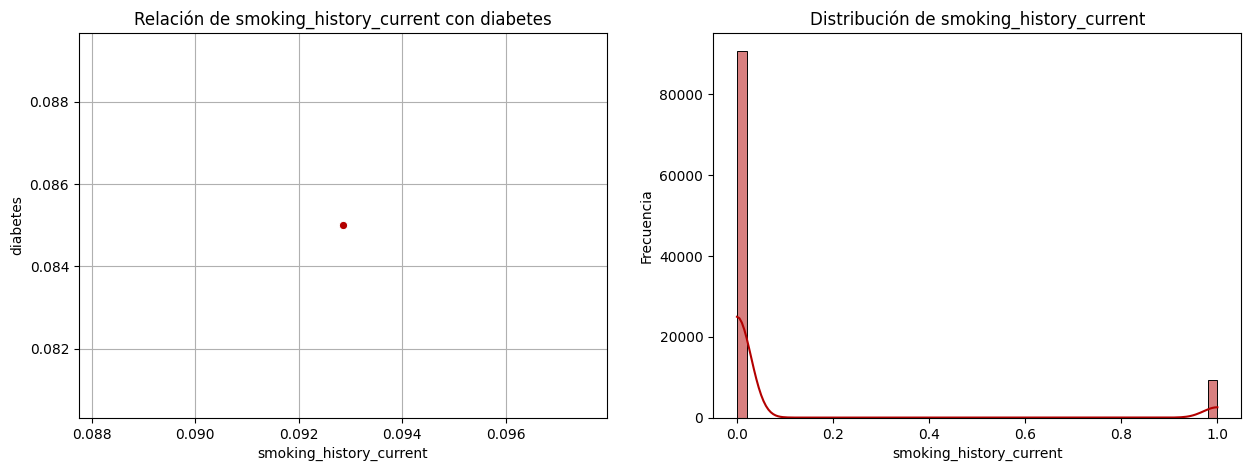

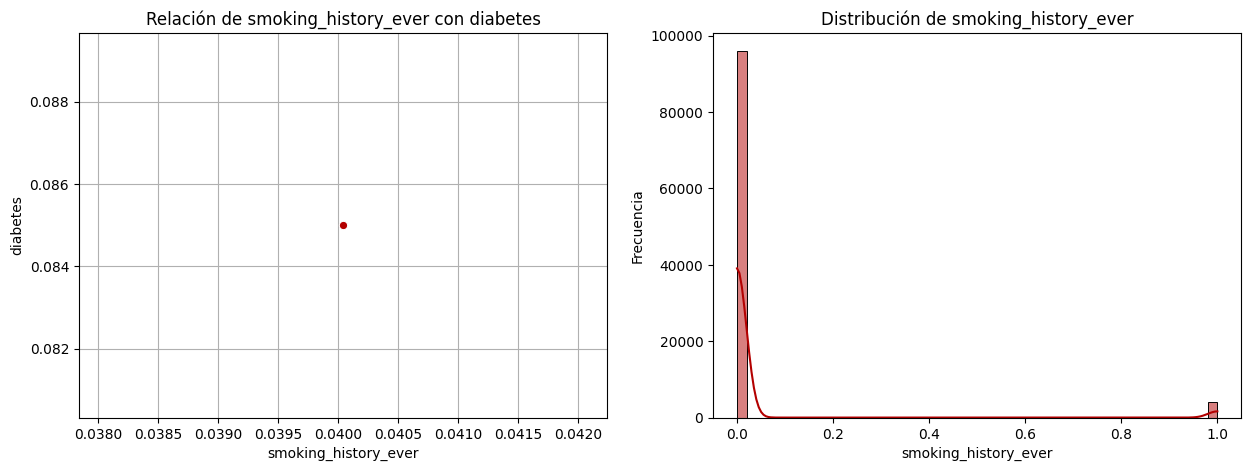

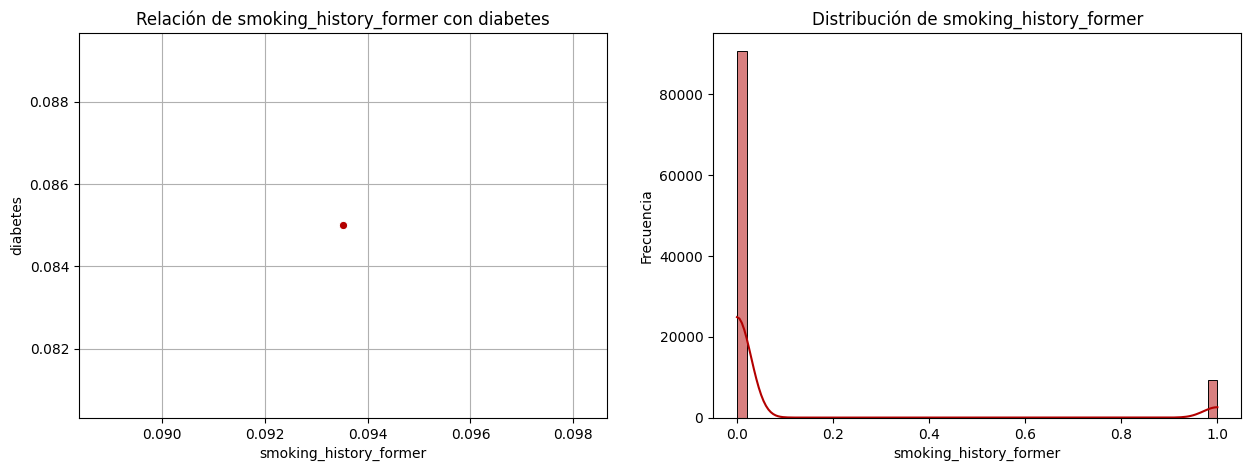

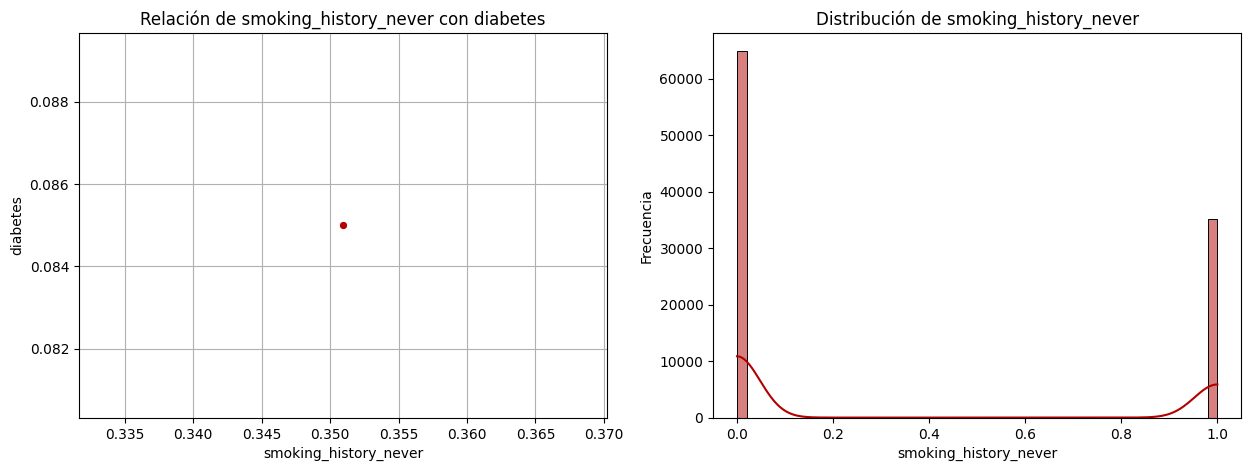

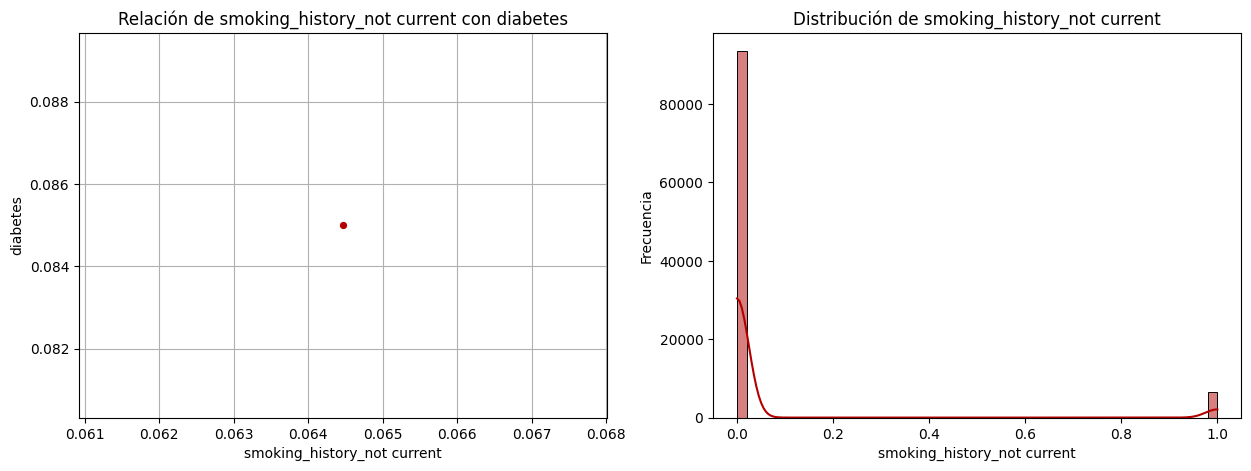

In [324]:
bivariado(df)

#### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

#### Correlación

In [325]:
df.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
age                            0.258008
bmi                            0.214357
hypertension                   0.197823
heart_disease                  0.171727
smoking_history_former         0.097917
gender_Male                    0.037666
smoking_history_never          0.027267
smoking_history_ever           0.024080
smoking_history_not current    0.020734
smoking_history_current        0.019606
gender_Other                  -0.004090
Name: diabetes, dtype: float64

In [326]:
df.drop('gender_Other', axis=1, inplace=True)

In [327]:
df.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
age                            0.258008
bmi                            0.214357
hypertension                   0.197823
heart_disease                  0.171727
smoking_history_former         0.097917
gender_Male                    0.037666
smoking_history_never          0.027267
smoking_history_ever           0.024080
smoking_history_not current    0.020734
smoking_history_current        0.019606
Name: diabetes, dtype: float64

## **Modelos**

## Arboles de decisión

Arbol con `max_depth`= 2 

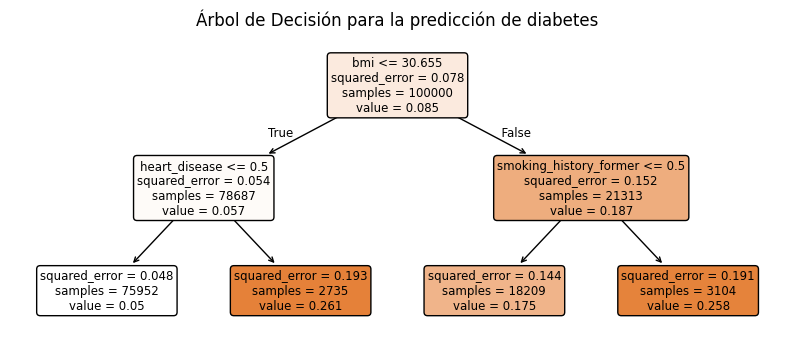

In [328]:
model = DecisionTreeRegressor(max_depth=2, random_state=42, 
                                  max_features='sqrt')
model.fit(X, y)

plt.figure(figsize=(10, 4)) 
plot_tree(model, feature_names=X.keys(), filled=True, rounded=True)
plt.title("Árbol de Decisión para la predicción de diabetes")
plt.show()


---

## Random Forest

### GridSearch

In [329]:
'''
pipeline= Pipeline([
    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42))
])

params= {
    'rf__max_depth': range(1, 10),
    'rf__max_features': ['log2', 'sqrt', 18 ,len(X_train.keys())],  
}

rf_grid= GridSearchCV(estimator= pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='r2')
rf_grid.fit(X_train, y_train)

rf_grid.best_params_
'''

"\npipeline= Pipeline([\n    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42))\n])\n\nparams= {\n    'rf__max_depth': range(1, 10),\n    'rf__max_features': ['log2', 'sqrt', 18 ,len(X_train.keys())],  \n}\n\nrf_grid= GridSearchCV(estimator= pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='r2')\nrf_grid.fit(X_train, y_train)\n\nrf_grid.best_params_\n"

In [330]:
'''
best_model= rf_grid.best_estimator_.named_steps['rf']
'''

"\nbest_model= rf_grid.best_estimator_.named_steps['rf']\n"

In [331]:
'''
predicciones_rf= best_model.predict(X_test)

print('R2: ', r2_score(y_pred= predicciones_rf, y_true=y_test))
'''

"\npredicciones_rf= best_model.predict(X_test)\n\nprint('R2: ', r2_score(y_pred= predicciones_rf, y_true=y_test))\n"

### RandomSearch

In [332]:

'''
random_search = RandomizedSearchCV(pipeline, param_distributions=param, n_iter=100, cv=3, n_jobs=-1)
random_search.fit(X_train, y_train)


random_search.best_params_
probabilidades_knn = random_search.predict_proba(X_test)[:, 1]

print(random_search.best_params_)
'''

'\nrandom_search = RandomizedSearchCV(pipeline, param_distributions=param, n_iter=100, cv=3, n_jobs=-1)\nrandom_search.fit(X_train, y_train)\n\n\nrandom_search.best_params_\nprobabilidades_knn = random_search.predict_proba(X_test)[:, 1]\n\nprint(random_search.best_params_)\n'

---

## Gradient Boosting

### Xgboost

In [333]:
import xgboost as xgb  # Ensure xgboost is imported with alias xgb

xgboost(X_train, y_train, X_test, y_test)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'callbacks'

#### Lightgm

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	training's auc: 0.840872	training's binary_logloss: 0.225582	valid_1's auc: 0.839397	valid_1's binary_logloss: 0.226495
ROC AUC: 0.8393972516875602


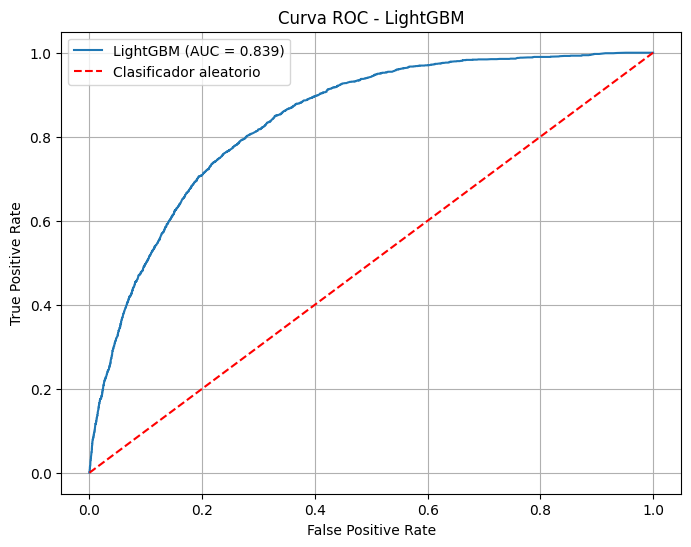

array([0.01195176, 0.01572916, 0.0548957 , ..., 0.02081053, 0.08297551,
       0.16238305])

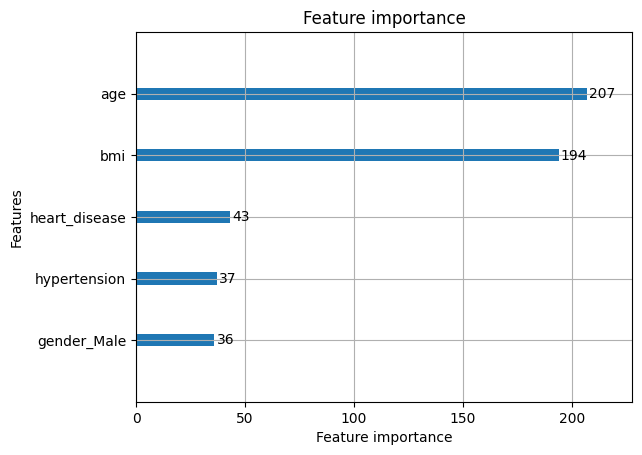

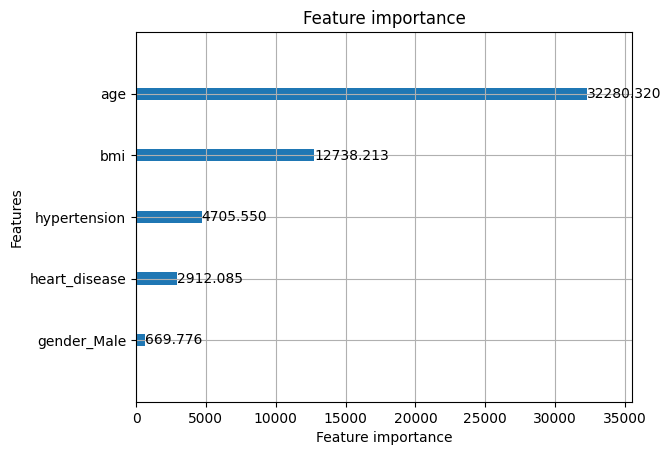

In [334]:
lightgbm(X_train, y_train, X_test, y_test)

### Catboost

0:	test: 0.7943872	best: 0.7943872 (0)	total: 18.7ms	remaining: 3m 7s
100:	test: 0.8395209	best: 0.8395871 (98)	total: 1.85s	remaining: 3m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8395871263
bestIteration = 98

Shrink model to first 99 iterations.
ROC AUC: 0.8395871263259402


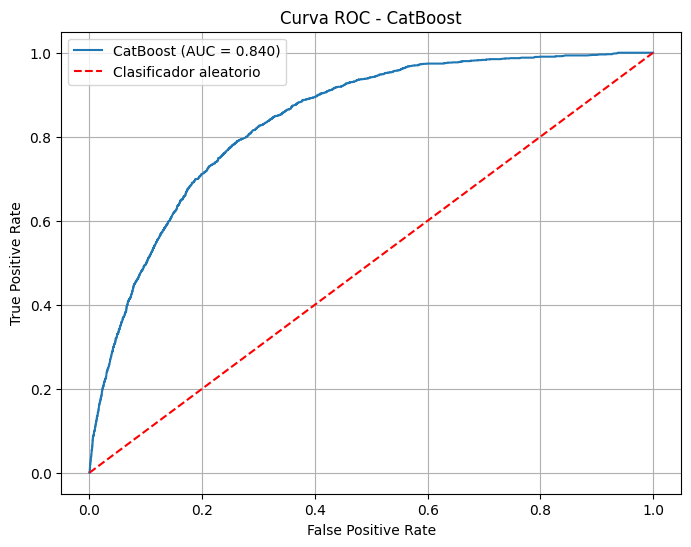

(         feature  importance
 0            age   62.760316
 3            bmi   22.087271
 1   hypertension    4.359583
 2  heart_disease    2.557542
 4    gender_Male    2.407395,
 array([0.01217951, 0.01122268, 0.06387399, ..., 0.01786852, 0.08507365,
        0.16333845]))

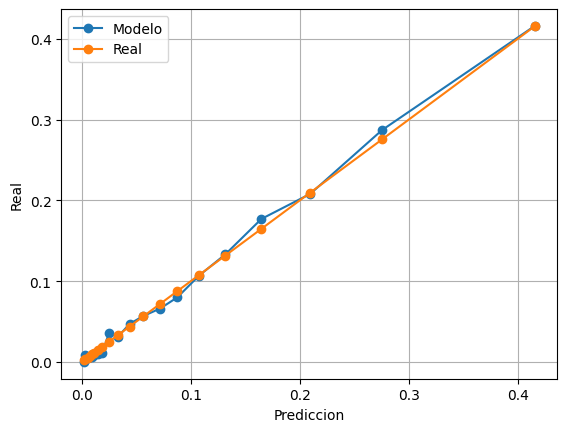

In [335]:
catboost(X_train, y_train, X_test, y_test)
